In [2]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [50]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from ToolBox import cardinalidad, describe_df
from sklearn.preprocessing import RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler, LabelEncoder, OneHotEncoder  # Added OneHotEncoder
from sklearn.model_selection import cross_val_score
from scipy.stats import shapiro
from scipy.stats import skew
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [8]:
#Redo everything
df = pd.read_csv("src/data_sample/gdp_model_focused.csv")
df["target"] = df["GDP growth (annual %)"]

df.drop(columns = ["GDP growth (annual %)"], inplace = True)






In [10]:

X_train, X_test, y_train, y_test = train_test_split(df.drop("target", axis=1),
                                                    df['target'],
                                                    test_size=0.2,
                                                    random_state=42)

X_train.drop(columns=["Services, value added (% of GDP)","School enrollment, secondary (% gross)", "Literacy rate, adult total (% of people ages 15 and above)","Access to electricity, rural (% of rural population)" ], inplace=True)
X_test.drop(columns=["Services, value added (% of GDP)","School enrollment, secondary (% gross)", "Literacy rate, adult total (% of people ages 15 and above)","Access to electricity, rural (% of rural population)" ], inplace=True)



In [12]:
X_train.columns

Index(['year', 'country', 'GDP per capita (constant 2015 US$)',
       'Gross fixed capital formation (% of GDP)',
       'Gross domestic savings (% of GDP)',
       'Inflation, GDP deflator (annual %)',
       'Exports of goods and services (% of GDP)',
       'Imports of goods and services (% of GDP)',
       'Foreign direct investment, net inflows (% of GDP)',
       'Population growth (annual %)',
       'Industry (including construction), value added (% of GDP)',
       'Agriculture, forestry, and fishing, value added (% of GDP)'],
      dtype='object')

In [15]:
X_train.shape
X_test.shape

(3380, 12)

Using sklearn imputation for remaining 9236 missing values
Using sklearn imputation for remaining 2594 missing values


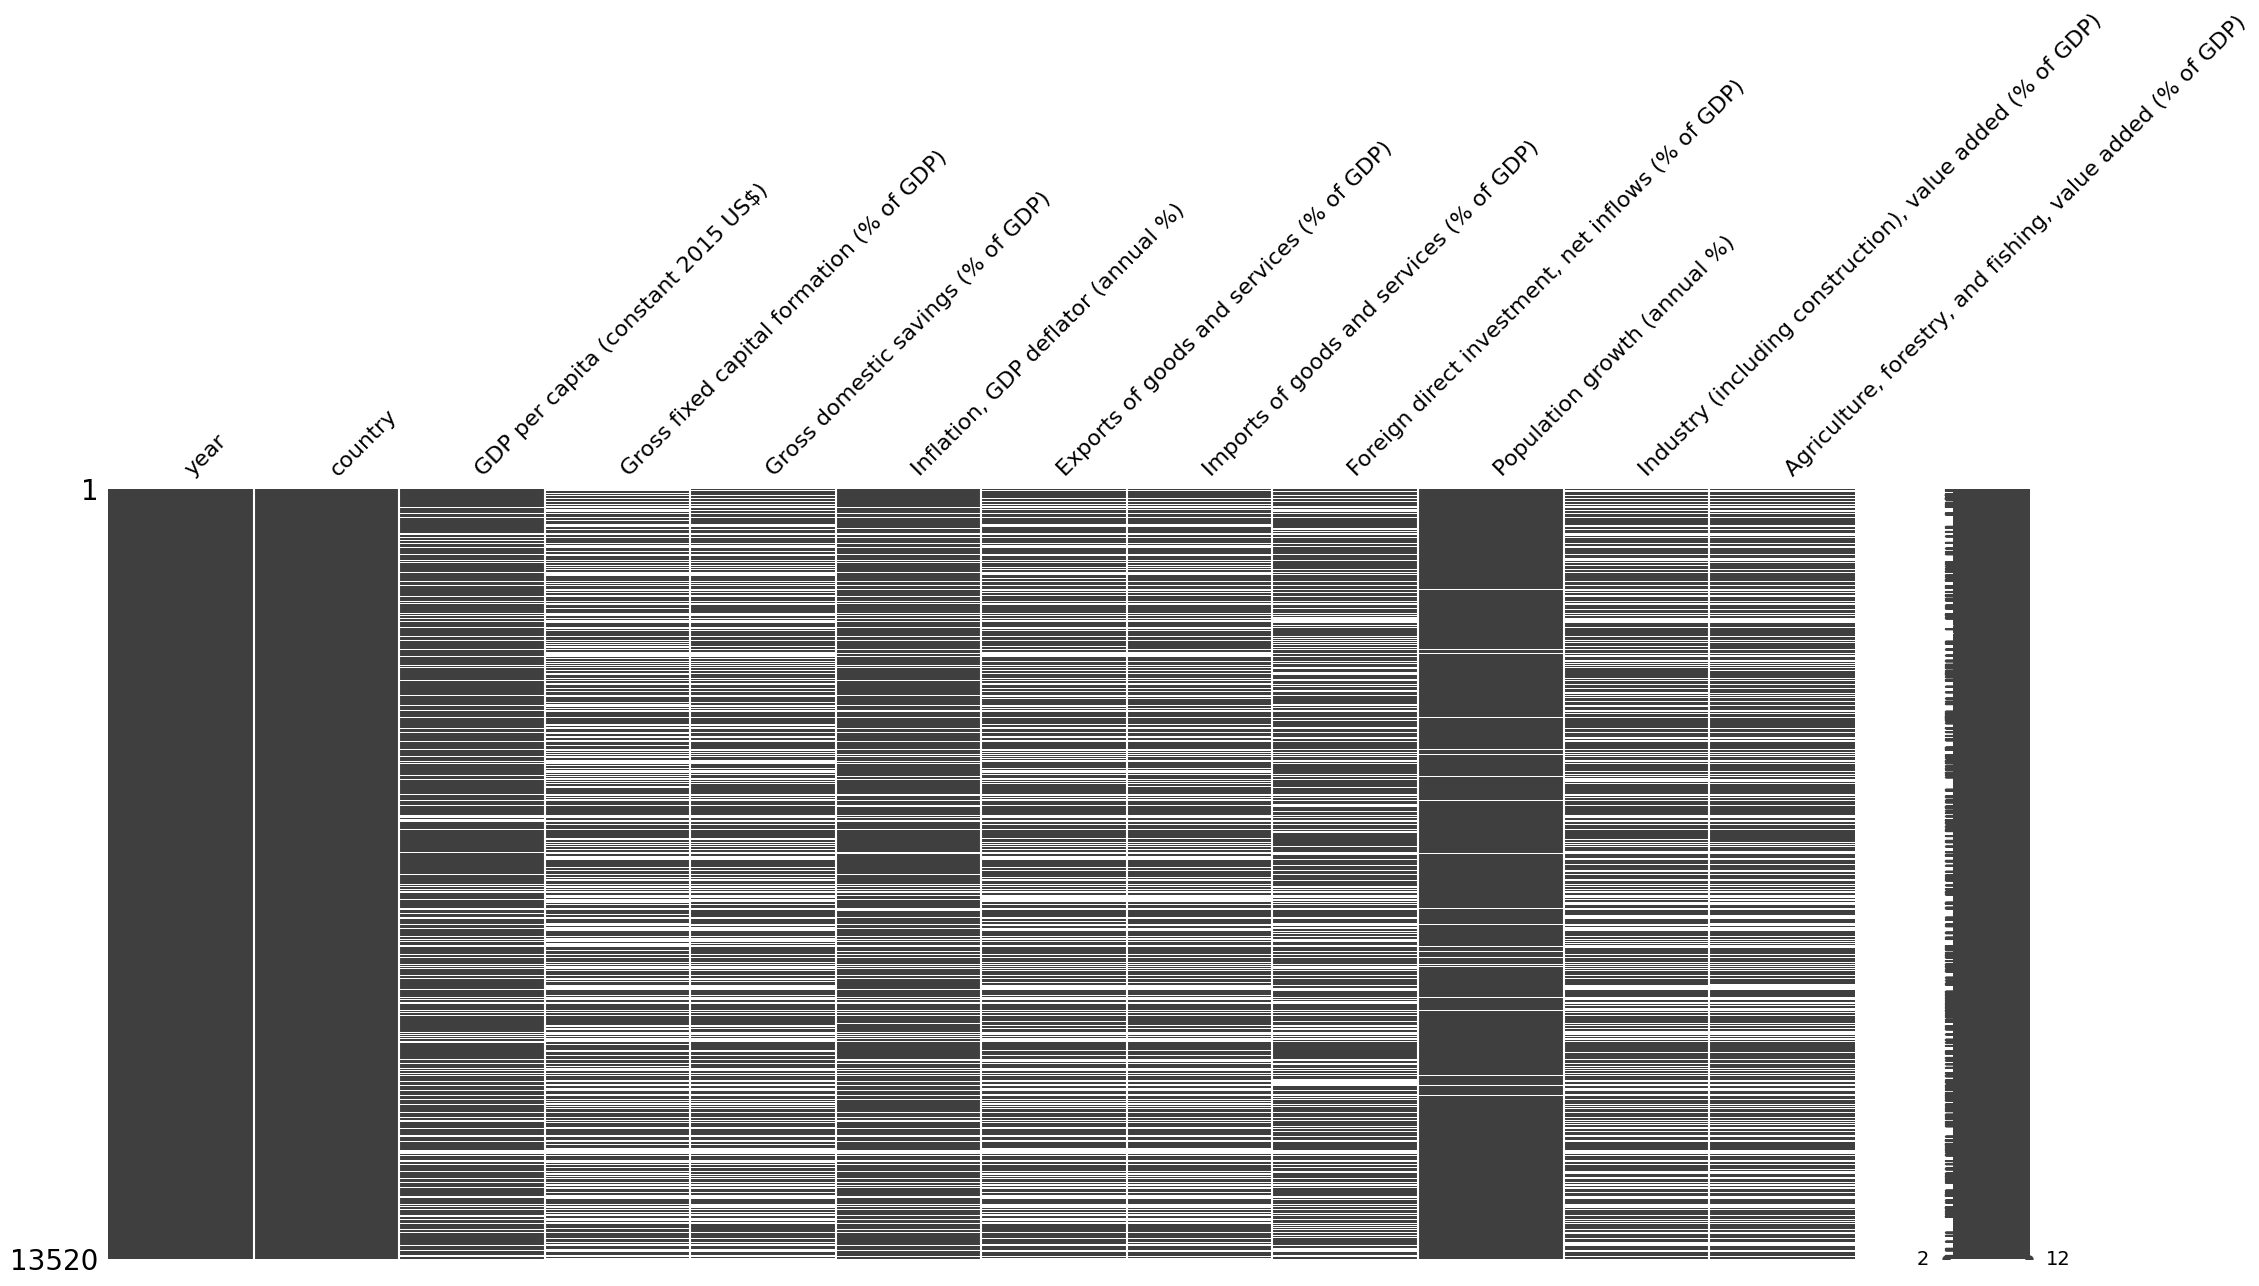

In [16]:
#Redo everything:

# 1. Analyze missing patterns in remaining data
import missingno as msno
msno.matrix(X_train) 

def hybrid_imputation(df):
    """Country-aware imputation with sklearn fallback"""
    from sklearn.impute import SimpleImputer
    
    df_imputed = df.copy()
    numeric_cols = df_imputed.select_dtypes(include=['float64', 'int64']).columns
    
    # Step 1: Try country-based imputation where possible
    if 'country' in df_imputed.columns:
        for col in numeric_cols:
            # Fill with country median where available
            df_imputed[col] = df_imputed.groupby('country')[col].transform(
                lambda x: x.fillna(x.median()) if x.notna().any() else x
            )
    
    # Step 2: Use sklearn for remaining missing values
    remaining_missing = df_imputed[numeric_cols].isnull().sum()
    if remaining_missing.sum() > 0:
        print(f"Using sklearn imputation for remaining {remaining_missing.sum()} missing values")
        imputer = SimpleImputer(strategy='median')
        df_imputed[numeric_cols] = imputer.fit_transform(df_imputed[numeric_cols])
    
    return df_imputed

# Use hybrid approach
X_train_imputed = hybrid_imputation(X_train)

X_test_imputed = hybrid_imputation(X_test)


<Axes: >

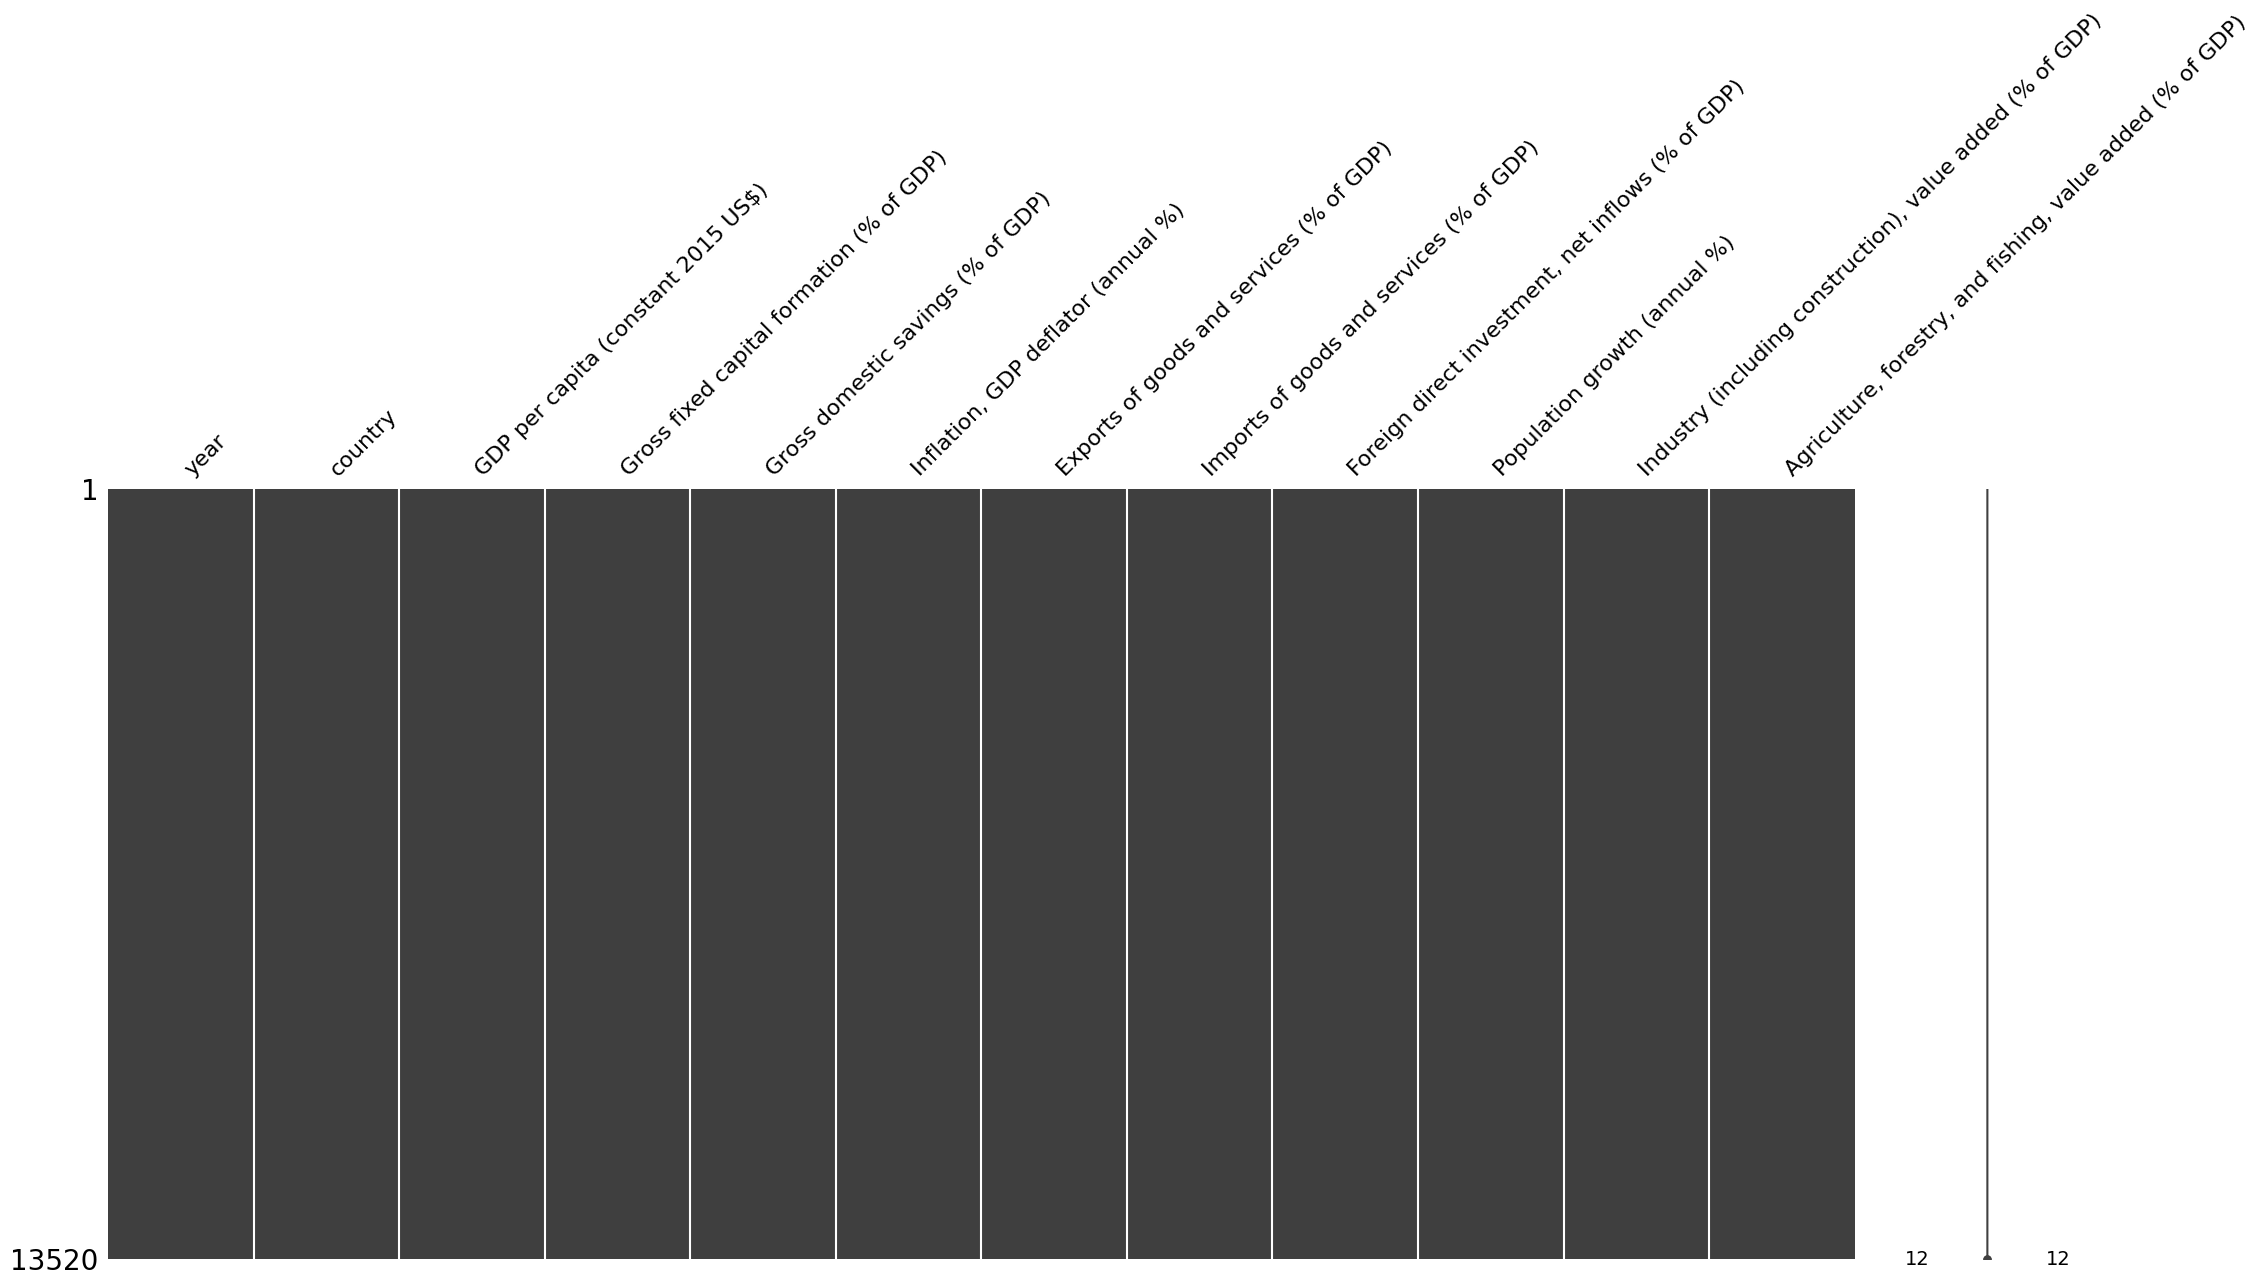

In [17]:
msno.matrix(X_train_imputed) 

<Axes: >

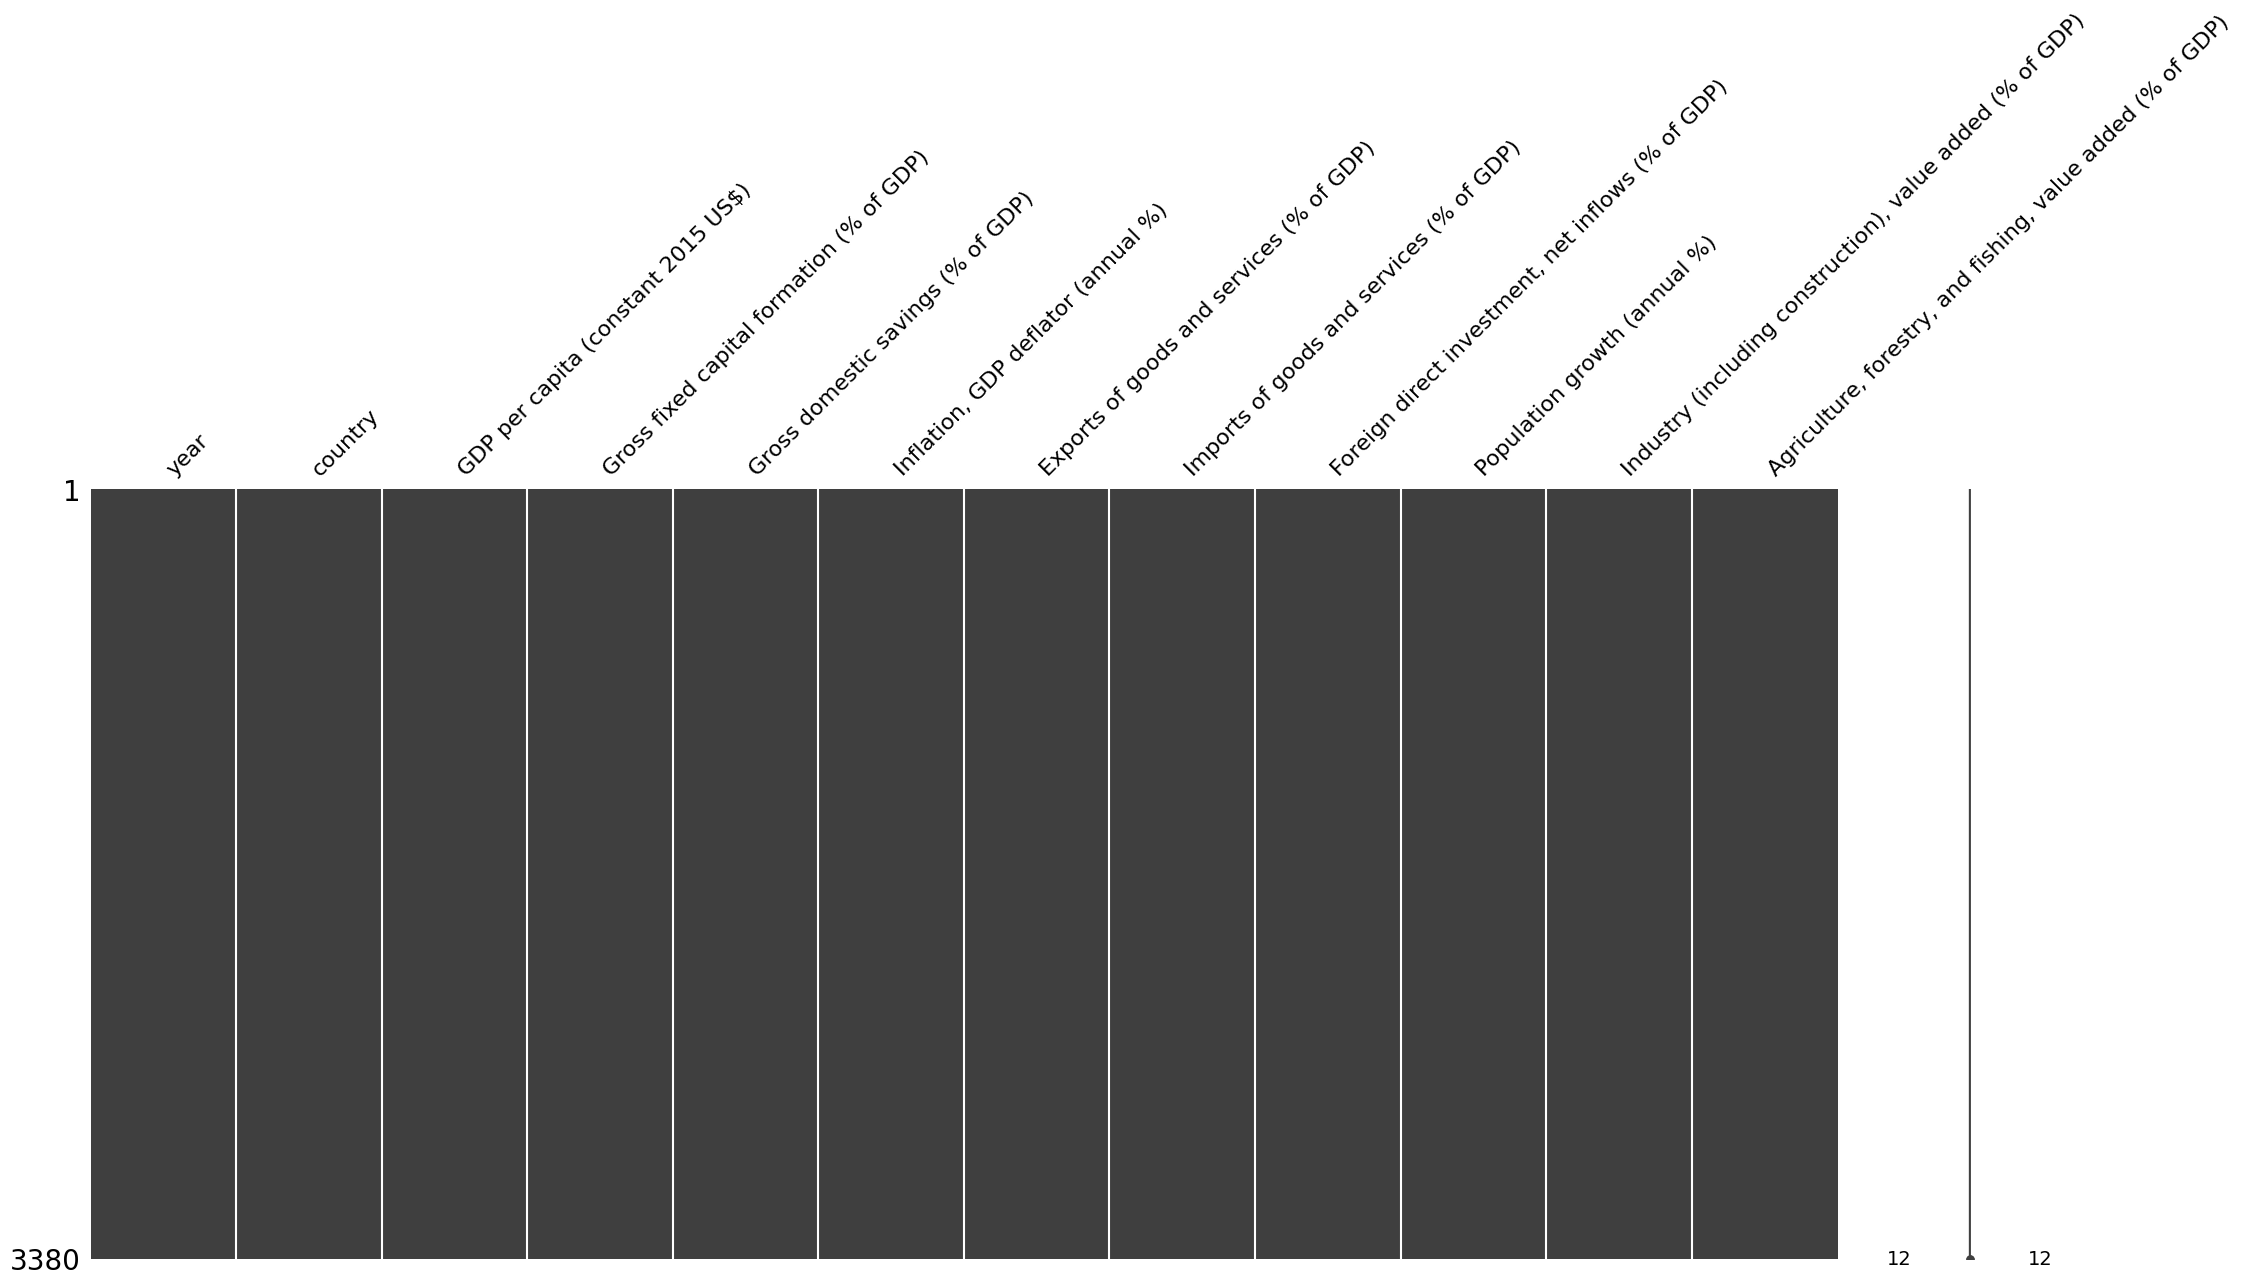

In [18]:
msno.matrix(X_test_imputed) 

In [ ]:
#All done with missings

# **10. Anomalies, errors and outliers**
Will most likely be keeping all of my outliers in this dataset:

1. Economic crises are real events (2008 financial crisis, COVID-19)
2. Rapid growth periods (emerging economies, post-war recovery)
3. Country-specific events (oil discoveries, natural disasters)
4. Regression models can handle outliers better than classification

=== TARGET VARIABLE ANALYSIS ===
Mean: 3.67
Median: 3.81
Std: 6.23
Min: -64.05
Max: 149.97

=== OUTLIER ANALYSIS ===
Outliers (IQR method): 954 (5.6%)
Outlier bounds: [-5.79, 13.32]

=== EXTREME VALUES ===
Top 5 highest GDP growth:
      country      target
9708      GNQ  149.972963
9749      LBR  106.279814
13650     LBY   86.826748
8445      KWT   82.809329
2258      OMN   81.887797

Top 5 lowest GDP growth:
      country     target
8171      IRQ -64.047107
15742     MAC -54.336155
7929      LBR -51.030865
13390     LBY -50.338515
9039      RWA -50.248067


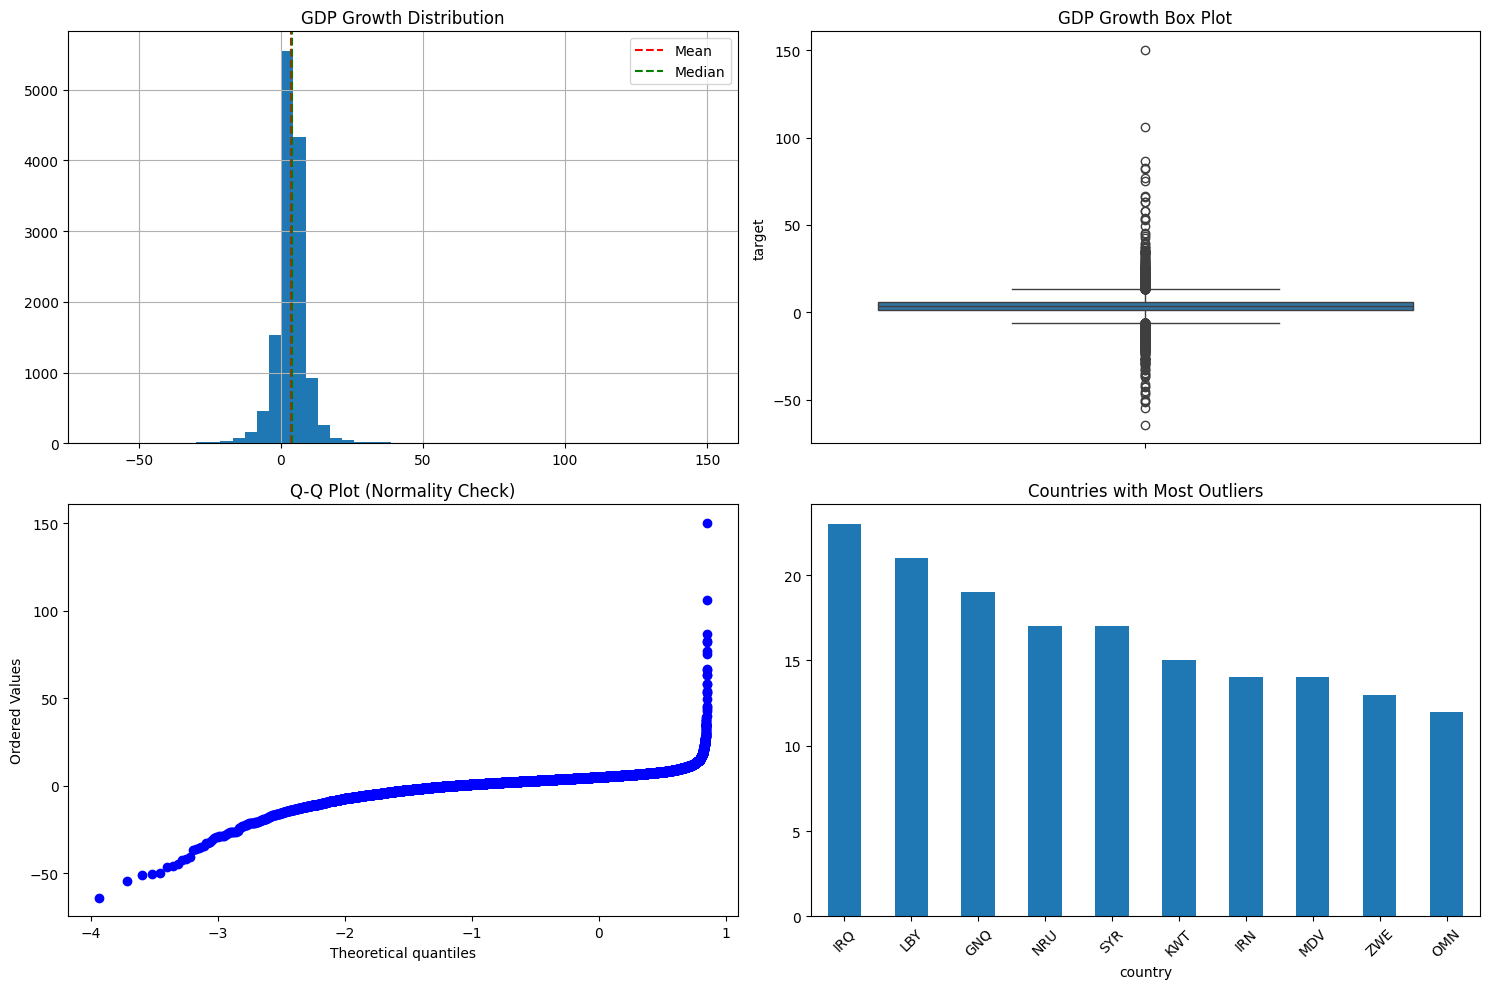

In [19]:
def analyze_outliers(df, target_col):
    """Analyze outliers without removing them"""
    
    # 1. Basic statistics
    print("=== TARGET VARIABLE ANALYSIS ===")
    print(f"Mean: {df[target_col].mean():.2f}")
    print(f"Median: {df[target_col].median():.2f}")
    print(f"Std: {df[target_col].std():.2f}")
    print(f"Min: {df[target_col].min():.2f}")
    print(f"Max: {df[target_col].max():.2f}")
    
    # 2. Identify statistical outliers (for information only)
    Q1 = df[target_col].quantile(0.25)
    Q3 = df[target_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[target_col] < lower_bound) | (df[target_col] > upper_bound)]
    print(f"\n=== OUTLIER ANALYSIS ===")
    print(f"Outliers (IQR method): {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")
    print(f"Outlier bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    
    # 3. Show extreme cases
    print(f"\n=== EXTREME VALUES ===")
    print("Top 5 highest GDP growth:")
    print(df.nlargest(5, target_col)[['country', target_col]])
    print("\nTop 5 lowest GDP growth:")
    print(df.nsmallest(5, target_col)[['country', target_col]])
    
    # 4. Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Histogram
    df[target_col].hist(bins=50, ax=axes[0,0])
    axes[0,0].set_title('GDP Growth Distribution')
    axes[0,0].axvline(df[target_col].mean(), color='red', linestyle='--', label='Mean')
    axes[0,0].axvline(df[target_col].median(), color='green', linestyle='--', label='Median')
    axes[0,0].legend()
    
    # Box plot
    sns.boxplot(y=df[target_col], ax=axes[0,1])
    axes[0,1].set_title('GDP Growth Box Plot')
    
    # Q-Q plot to check normality
    from scipy import stats
    stats.probplot(df[target_col], dist="norm", plot=axes[1,0])
    axes[1,0].set_title('Q-Q Plot (Normality Check)')
    
    # Outliers by country (if you have country column)
    if 'country' in df.columns:
        outlier_countries = outliers['country'].value_counts().head(10)
        outlier_countries.plot(kind='bar', ax=axes[1,1])
        axes[1,1].set_title('Countries with Most Outliers')
        axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return outliers

# Analyze your data
outliers_df = analyze_outliers(df, 'target')

# **11. Feature engineering**

In [51]:
print(X_train_imputed.columns)

Index(['year', 'country', 'GDP per capita (constant 2015 US$)',
       'Gross fixed capital formation (% of GDP)',
       'Gross domestic savings (% of GDP)',
       'Inflation, GDP deflator (annual %)',
       'Exports of goods and services (% of GDP)',
       'Imports of goods and services (% of GDP)',
       'Foreign direct investment, net inflows (% of GDP)',
       'Population growth (annual %)',
       'Industry (including construction), value added (% of GDP)',
       'Agriculture, forestry, and fishing, value added (% of GDP)'],
      dtype='object')


In [20]:
# RobustScaler is best for economic data because:
# 1. Uses median instead of mean (less sensitive to outliers)
# 2. Uses IQR instead of standard deviation
# 3. Economic data often has outliers (crises, booms)

In [21]:
print("Number of unique countries:", X_train['country'].nunique())
print("Countries with most data points:")
print(X_train['country'].value_counts().head(10))
print("\nCountries with least data points:")
print(X_train['country'].value_counts().tail(5))

Number of unique countries: 260
Countries with most data points:
country
JOR    59
IMN    59
PSE    58
NIC    58
SGP    58
PRE    58
KOR    58
TSS    58
CHE    58
SVK    58
Name: count, dtype: int64

Countries with least data points:
country
COG    44
PRT    43
TON    42
FIN    42
BRN    38
Name: count, dtype: int64


In [22]:
print(X_train_imputed.shape)
print(y_train.shape)

(13520, 12)
(13520,)


In [23]:
print(X_train_imputed.isna().sum().sum())

0


In [24]:
print(X_test_imputed.isna().sum().sum())

0


In [25]:
#Since I do have NaN on y_test and y_train, I will use a mask
mask = y_train.notna()
X_train_imputed = X_train_imputed[mask]
y_train = y_train[mask]


In [26]:
X_test_imputed = X_test_imputed.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [27]:
mask = y_test.notna()
X_test_imputed = X_test_imputed[mask]
y_test = y_test[mask]

In [28]:

def create_preprocessing_pipelines(X_train, X_test):
    """Create separate pipelines for different model types"""
    
    # Identify column types
    numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Remove 'country' from numeric if it exists there
    if 'country' in numeric_cols:
        numeric_cols.remove('country')
    
    # For LINEAR REGRESSION (needs scaling + encoding)
    preprocessor_scaled = ColumnTransformer(
        transformers=[
            ('num', RobustScaler(), numeric_cols),
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['country'])
        ],
        remainder='drop'
    )
    
    # For TREE MODELS (no scaling, but still encode country)
    preprocessor_unscaled = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numeric_cols),
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['country'])
        ],
        remainder='drop'
    )
    
    return preprocessor_scaled, preprocessor_unscaled

def create_tree_friendly_preprocessing(X_train, X_test):
    """Label encode countries for tree models (more efficient)"""
    
    X_train_processed = X_train.copy()
    X_test_processed = X_test.copy()
    
    # Label encode country
    le = LabelEncoder()
    X_train_processed['country_encoded'] = le.fit_transform(X_train_processed['country'])
    
    # Handle unknown countries in test set
    X_test_processed['country_encoded'] = X_test_processed['country'].map(
        dict(zip(le.classes_, le.transform(le.classes_)))
    ).fillna(-1)  # Unknown country = -1
    
    # Drop original country column
    X_train_processed = X_train_processed.drop('country', axis=1)
    X_test_processed = X_test_processed.drop('country', axis=1)
    
    return X_train_processed, X_test_processed, le

def compare_all_models(X_train, X_test, y_train, y_test):
    """Compare all models with appropriate preprocessing"""
    
    results = {}
    
    # 1. LINEAR REGRESSION (with scaling + one-hot encoding)
    numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
    if 'country' in numeric_cols:
        numeric_cols.remove('country')
    
    linear_pipeline = Pipeline([
        ('preprocessor', ColumnTransformer([
            ('num', RobustScaler(), numeric_cols),
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['country'])
        ])),
        ('model', LinearRegression())
    ])
    
    # 2. TREE MODELS (no scaling + label encoding)
    # Prepare data for tree models
    X_train_trees, X_test_trees, country_encoder = create_tree_friendly_preprocessing(X_train, X_test)  # Fixed typo
    
    tree_models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    # Evaluate Linear Regression
    lr_scores = cross_val_score(linear_pipeline, X_train, y_train, cv=5, scoring='r2')
    results['Linear Regression'] = {
        'CV Score': lr_scores.mean(),
        'CV Std': lr_scores.std(),
        'Pipeline': linear_pipeline
    }
    
    # Evaluate Tree Models
    for name, model in tree_models.items():
        scores = cross_val_score(model, X_train_trees, y_train, cv=5, scoring='r2')
        results[name] = {
            'CV Score': scores.mean(),
            'CV Std': scores.std(),
            'Pipeline': model,
            'Preprocessed_Data': (X_train_trees, X_test_trees),  # Store for later use
            'Country_Encoder': country_encoder
        }
    
    return results

# Usage:
# Create pipelines (if you want to use the pipeline approach)
preprocessor_scaled, preprocessor_unscaled = create_preprocessing_pipelines(X_train_imputed, X_test_imputed)

# Create all model pipelines (alternative approach)
models = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor_scaled),
        ('model', LinearRegression())
    ]),
    
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor_unscaled),
        ('model', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor_unscaled),
        ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])
}

# For tree models - more efficient approach
X_train_trees, X_test_trees, country_encoder = create_tree_friendly_preprocessing(
    X_train_imputed, X_test_imputed
)

# Run comparison
model_results = compare_all_models(X_train_imputed, X_test_imputed, y_train, y_test)

# Display results
print("=== MODEL COMPARISON ===")
for model_name, metrics in model_results.items():
    print(f"{model_name}: R² = {metrics['CV Score']:.3f} (+/- {metrics['CV Std']*2:.3f})")

# Optional: Test both approaches to see if there's a difference
print("\n=== PIPELINE APPROACH COMPARISON ===")
for name, pipeline in models.items():
    if 'Linear' in name:
        scores = cross_val_score(pipeline, X_train_imputed, y_train, cv=5, scoring='r2')
    else:
        scores = cross_val_score(pipeline, X_train_imputed, y_train, cv=5, scoring='r2')
    print(f"{name}: R² = {scores.mean():.3f} (+/- {scores.std()*2:.3f})")

=== MODEL COMPARISON ===
Linear Regression: R² = 0.064 (+/- 0.023)
Random Forest: R² = 0.243 (+/- 0.088)
Gradient Boosting: R² = 0.167 (+/- 0.088)

=== PIPELINE APPROACH COMPARISON ===
Linear Regression: R² = 0.064 (+/- 0.023)
Random Forest: R² = 0.234 (+/- 0.098)
Gradient Boosting: R² = 0.167 (+/- 0.083)


In [29]:
X_train_trees, X_test_trees, _ = create_tree_friendly_preprocessing(X_train_imputed, X_test_imputed)

In [30]:
print(f"Training set: {X_train_imputed.shape}")
print(f"Test set: {X_test_imputed.shape}")

Training set: (10846, 12)
Test set: (2729, 12)


In [31]:
print(X_train_trees.isna().sum().sum())

0


In [32]:
print(X_train_trees.isna().sum().sum())

0


In [33]:
print(y_train.isna().sum().sum())

0


In [34]:
print(y_test.isna().sum().sum())

0


# **12. Models**

In [35]:
# Create all model pipelines
models = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor_scaled),
        ('model', LinearRegression())
    ]),
    
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor_unscaled),
        ('model', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor_unscaled),
        ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])
}

In [36]:

def compare_all_models(X_train, X_test, y_train, y_test):
    """Compare all models with appropriate preprocessing"""
    
    results = {}
    
    # 1. LINEAR REGRESSION (with scaling + one-hot encoding)
    linear_pipeline = Pipeline([
        ('preprocessor', ColumnTransformer([
            ('num', RobustScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns),
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['country'])
        ])),
        ('model', LinearRegression())
    ])
    
    # 2. TREE MODELS (no scaling + label encoding)
    

    
    tree_models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    # Evaluate Linear Regression
    lr_scores = cross_val_score(linear_pipeline, X_train, y_train, cv=5, scoring='r2')
    results['Linear Regression'] = {
        'CV Score': lr_scores.mean(),
        'CV Std': lr_scores.std(),
        'Pipeline': linear_pipeline
    }
    
    # Evaluate Tree Models
    for name, model in tree_models.items():
        scores = cross_val_score(model, X_train_trees, y_train, cv=5, scoring='r2')
        results[name] = {
            'CV Score': scores.mean(),
            'CV Std': scores.std(),
            'Pipeline': model
        }
    
    return results

# Run comparison
model_results = compare_all_models(X_train_imputed, X_test_imputed, y_train, y_test)

# Display results
print("=== MODEL COMPARISON ===")
for model_name, metrics in model_results.items():
    print(f"{model_name}: R² = {metrics['CV Score']:.3f} (+/- {metrics['CV Std']*2:.3f})")

=== MODEL COMPARISON ===
Linear Regression: R² = 0.064 (+/- 0.023)
Random Forest: R² = 0.243 (+/- 0.088)
Gradient Boosting: R² = 0.167 (+/- 0.088)


In [37]:
model_results

{'Linear Regression': {'CV Score': np.float64(0.06401067519754924),
  'CV Std': np.float64(0.01152465680644303),
  'Pipeline': Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('num', RobustScaler(),
                                                    Index(['year', 'GDP per capita (constant 2015 US$)',
         'Gross fixed capital formation (% of GDP)',
         'Gross domestic savings (% of GDP)',
         'Inflation, GDP deflator (annual %)',
         'Exports of goods and services (% of GDP)',
         'Imports of goods and services (% of GDP)',
         'Foreign direct investment, net inflows (% of GDP)',
         'Population growth (annual %)',
         'Industry (including construction), value added (% of GDP)',
         'Agriculture, forestry, and fishing, value added (% of GDP)'],
        dtype='object')),
                                                   ('cat',
                                                    OneHotEncoder(drop='first'

In [38]:
# After fitting Random Forest, check country importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_trees, y_train)

# Get feature importance
feature_names = X_train_trees.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10))

Top 10 Most Important Features:
                                              feature  importance
4                  Inflation, GDP deflator (annual %)    0.152395
8                        Population growth (annual %)    0.137644
0                                                year    0.120673
7   Foreign direct investment, net inflows (% of GDP)    0.104404
9   Industry (including construction), value added...    0.086742
3                   Gross domestic savings (% of GDP)    0.072404
1                  GDP per capita (constant 2015 US$)    0.072396
2            Gross fixed capital formation (% of GDP)    0.063757
10  Agriculture, forestry, and fishing, value adde...    0.054970
6            Imports of goods and services (% of GDP)    0.052723


In [39]:
X_test_trees = X_test_trees[X_train_trees.columns]

In [40]:
print(X_train_trees.columns.equals(X_test_trees.columns))

True


In [41]:
#Model 1: Random Forest

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_trees, y_train)
y_pred = model.predict(X_test_trees[X_train_trees.columns])  # Ensure column match

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")

RMSE: 5.87
MAE: 3.07
R²: 0.145


In [42]:
# Model 2:  Gradient Boosting
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr_model.fit(X_train_trees, y_train)

# Ensure test set has same columns
y_pred_gbr = gbr_model.predict(X_test_trees[X_train_trees.columns])

# Evaluate
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print("=== Gradient Boosting Performance ===")
print(f"RMSE: {rmse_gbr:.2f}")
print(f"MAE: {mae_gbr:.2f}")
print(f"R²: {r2_gbr:.3f}")

=== Gradient Boosting Performance ===
RMSE: 5.95
MAE: 3.37
R²: 0.122


In [43]:

# Model 3: Linear Regression
linear_pipeline = Pipeline([
    ('preprocessor', preprocessor_scaled),
    ('model', LinearRegression())
])
linear_pipeline.fit(X_train_imputed, y_train)

# Predict on test data
y_pred_lr = linear_pipeline.predict(X_test_imputed)

# Evaluate
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("=== Linear Regression Test Performance ===")
print(f"RMSE: {rmse_lr:.2f}")
print(f"MAE: {mae_lr:.2f}")
print(f"R²: {r2_lr:.3f}")

=== Linear Regression Test Performance ===
RMSE: 6.18
MAE: 3.50
R²: 0.053


In [44]:
from sklearn.linear_model import ElasticNet

# Model 4: ElasticNet
elastic_pipeline = Pipeline([
    ('preprocessor', preprocessor_scaled),
    ('model', ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42))
])
elastic_pipeline.fit(X_train_imputed, y_train)

# Predict
y_pred_en = elastic_pipeline.predict(X_test_imputed)

# Evaluate
rmse_en = np.sqrt(mean_squared_error(y_test, y_pred_en))
mae_en = mean_absolute_error(y_test, y_pred_en)
r2_en = r2_score(y_test, y_pred_en)
mape_en = np.mean(np.abs((y_test - y_pred_en) / y_test)) * 100

print("=== ElasticNet Test Performance ===")
print(f"RMSE: {rmse_en:.2f}")
print(f"MAE: {mae_en:.2f}")
print(f"R²: {r2_en:.3f}")
print(f"MAPE: {mape_en:.2f}%")

=== ElasticNet Test Performance ===
RMSE: 6.27
MAE: 3.63
R²: 0.026
MAPE: inf%


In [45]:
from lightgbm import LGBMRegressor

# Model 5:  LightGBM
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor_scaled),
    ('model', LGBMRegressor(n_estimators=100, random_state=42))
])
lgbm_pipeline.fit(X_train_imputed, y_train)

# Predict
y_pred_lgb = lgbm_pipeline.predict(X_test_imputed)

# Evaluate
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)
mape_lgb = np.mean(np.abs((y_test - y_pred_lgb) / y_test)) * 100

print("=== LightGBM Test Performance ===")
print(f"RMSE: {rmse_lgb:.2f}")
print(f"MAE: {mae_lgb:.2f}")
print(f"R²: {r2_lgb:.3f}")
print(f"MAPE: {mape_lgb:.2f}%")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3093
[LightGBM] [Info] Number of data points in the train set: 10846, number of used features: 251
[LightGBM] [Info] Start training from score 3.726895
=== LightGBM Test Performance ===
RMSE: 5.78
MAE: 3.11
R²: 0.171
MAPE: inf%


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [46]:
from xgboost import XGBRegressor

#Model 6 : XGBoost


xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor_scaled),
    ('model', XGBRegressor(n_estimators=100, random_state=42, verbosity=0))
])
xgb_pipeline.fit(X_train_imputed, y_train)

# Predict
y_pred_xgb = xgb_pipeline.predict(X_test_imputed)

# Evaluate
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100

print("=== XGBoost Test Performance ===")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"MAE: {mae_xgb:.2f}")
print(f"R²: {r2_xgb:.3f}")
print(f"MAPE: {mape_xgb:.2f}%")

=== XGBoost Test Performance ===
RMSE: 5.92
MAE: 3.14
R²: 0.131
MAPE: inf%


#### After trying out this 6 models, I will choose LightGBM for the RMSE of 5.78, I care about accurately capturing volatile economic events and RMSE penalizes larger errors more heavily. R2 is also a good barometer because  its helping me see how well my model explains the variation in GDP growth across all conditions.

# **13. LightGBM**

In [55]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor, early_stopping
import numpy as np
import scipy.stats as stats
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
#Random seah Test#1
# Define numeric and categorical columns
numeric_cols = X_train_imputed.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'country' in numeric_cols:
    numeric_cols.remove('country')

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['country'])
    ]
)

# Full pipeline with LightGBM
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state=42))
])

# Define hyperparameter distributions
param_dist = {
    'model__n_estimators': [100, 200, 300, 500],
    'model__learning_rate': stats.uniform(0.01, 0.2),
    'model__num_leaves': [31, 50, 100, 150],
    'model__max_depth': [-1, 10, 20, 30],
    'model__min_child_samples': [20, 30, 50],
    'model__subsample': [0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.8, 0.9, 1.0],
    'model__reg_alpha': [0, 0.1, 0.5],
    'model__reg_lambda': [0, 0.1, 0.5],
}

# Randomized search with early stopping
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,  # Reduce/increase for speed vs thoroughness
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit preprocessor separately to transform X_test for early stopping
preprocessor.fit(X_train_imputed)
X_test_processed = preprocessor.transform(X_test_imputed)

# Fit the model
random_search.fit(
    X_train_imputed,
    y_train,
    model__eval_set=[(X_test_processed, y_test)],
    model__eval_metric='rmse',
    model__callbacks=[early_stopping(stopping_rounds=10)]
)

# Get best model and predict
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_imputed)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Report
print("\n=== LightGBM (Tuned) Test Performance ===")
print(f"Best Params: {random_search.best_params_}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAPE: {mape * 100:.2f}%")

NameError: name 'stats' is not defined

In [ ]:
print("\n=== LightGBM (Tuned) Test Performance ===")
print(f"Best Params: {random_search.best_params_}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAPE: {mape*100:.2f}%")

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual GDP Growth")
plt.ylabel("Predicted GDP Growth")
plt.title("Predicted vs. Actual GDP Growth (LightGBM)")
plt.grid(True)
plt.show()

⚡ Starting FAST RMSE-optimized search...
📊 Total combinations to test: 30
🔄 Cross-validation folds: 3
🚀 Optimized for speed while maintaining effectiveness...
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/skle


🎯==========================================================🎯
    RMSE-OPTIMIZED LIGHTGBM SEARCH RESULTS
🎯==========================================================🎯
🏆 Best CV RMSE: 5.3904
📈 CV Score Improvement: 0.4614

🔧 Best Parameters:
   subsample: 1.0
   reg_lambda: 0.5
   reg_alpha: 1.0
   num_leaves: 200
   n_estimators: 300
   min_child_samples: 10
   max_depth: -1
   learning_rate: 0.01
   colsample_bytree: 0.8

📊 Test Performance:
   🎯 RMSE: 5.7536
   📏 MAE: 3.0714
   📈 R²: 0.1787
   📊 MAPE: 1098884869128848.50%

🏋️ Train Performance:
   🎯 RMSE: 4.1268
   📈 R²: 0.5568
   ⚠️  Overfitting Check: 0.3781 R² difference

📊 Generating key RMSE visualizations...


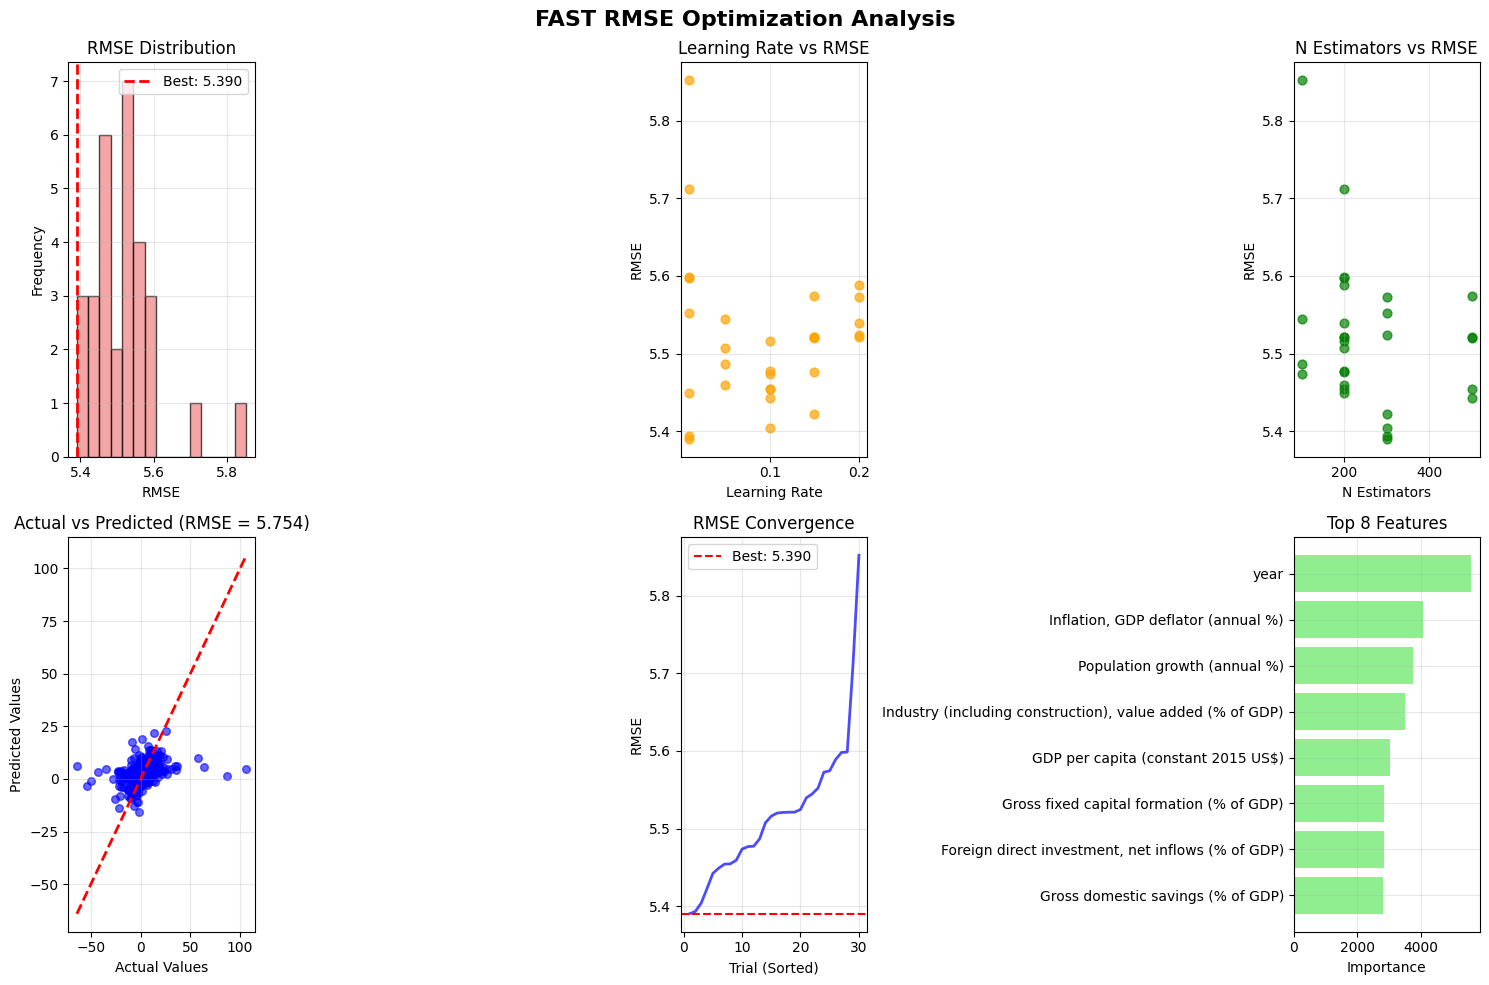


⚡ FAST RMSE OPTIMIZATION SUMMARY:
🎯 Final Test RMSE: 5.7536
🏆 Best CV RMSE: 5.3904
🔄 Total trials: 30
📈 RMSE range: 5.3904 - 5.8519
⚠️  Overfitting detected (R² diff: 0.378)

⚡ FAST Optimization Complete! (30 trials, 3-fold CV)


In [56]:
#Test #2
# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Define numeric and categorical columns
numeric_cols = X_train_imputed.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'country' in numeric_cols:
    numeric_cols.remove('country')

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['country'])
    ]
)

# Full pipeline with LightGBM
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state=42, verbose=-1))
])

# FAST hyperparameter distributions for RMSE reduction
param_dist = {
    # Core parameters - focused ranges for speed
    'model__n_estimators': [100, 200, 300, 500],  # Discrete values for speed
    'model__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],  # Discrete values
    'model__num_leaves': [31, 50, 100, 150, 200],  # Key values only
    'model__max_depth': [-1, 5, 10, 15],  # Reduced options
    
    # Key regularization parameters
    'model__min_child_samples': [10, 20, 30, 50],  # Discrete values
    'model__subsample': [0.7, 0.8, 0.9, 1.0],  # Key values
    'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Key values
    
    # Essential regularization
    'model__reg_alpha': [0, 0.1, 0.5, 1.0],  # Discrete values
    'model__reg_lambda': [0, 0.1, 0.5, 1.0],  # Discrete values
}

# FAST randomized search - optimized for speed
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,  # Reduced for speed
    cv=3,  # Reduced CV folds for speed
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

print("⚡ Starting FAST RMSE-optimized search...")
print(f"📊 Total combinations to test: {random_search.n_iter}")
print(f"🔄 Cross-validation folds: {random_search.cv}")
print("🚀 Optimized for speed while maintaining effectiveness...")

# Fit preprocessor separately to transform X_test for early stopping
preprocessor.fit(X_train_imputed)
X_test_processed = preprocessor.transform(X_test_imputed)

# Fit the model with enhanced early stopping for RMSE
random_search.fit(
    X_train_imputed,
    y_train,
    model__eval_set=[(X_test_processed, y_test)],
    model__eval_metric='rmse',
    model__callbacks=[early_stopping(stopping_rounds=10, verbose=False)]  # Faster stopping
)

# Get best model and predict
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_imputed)
y_train_pred = best_model.predict(X_train_imputed)

# Calculate comprehensive metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

# Enhanced reporting
print("\n" + "🎯" + "="*58 + "🎯")
print("    RMSE-OPTIMIZED LIGHTGBM SEARCH RESULTS")
print("🎯" + "="*58 + "🎯")
print(f"🏆 Best CV RMSE: {-random_search.best_score_:.4f}")
print(f"📈 CV Score Improvement: {(random_search.cv_results_['mean_test_score'].max() - random_search.cv_results_['mean_test_score'].min()):.4f}")

print(f"\n🔧 Best Parameters:")
for param, value in random_search.best_params_.items():
    print(f"   {param.replace('model__', '')}: {value}")

print(f"\n📊 Test Performance:")
print(f"   🎯 RMSE: {rmse:.4f}")
print(f"   📏 MAE: {mae:.4f}")
print(f"   📈 R²: {r2:.4f}")
print(f"   📊 MAPE: {mape*100:.2f}%")

print(f"\n🏋️ Train Performance:")
print(f"   🎯 RMSE: {rmse_train:.4f}")
print(f"   📈 R²: {r2_train:.4f}")
print(f"   ⚠️  Overfitting Check: {(r2_train - r2):.4f} R² difference")

# STREAMLINED visualization for speed
print("\n📊 Generating key RMSE visualizations...")

# Create focused results analysis
results_df = pd.DataFrame(random_search.cv_results_)
results_df['rmse_score'] = -results_df['mean_test_score']

# Create focused visualization - 6 key plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('FAST RMSE Optimization Analysis', fontsize=16, fontweight='bold')

# 1. RMSE Distribution
ax = axes[0, 0]
ax.hist(results_df['rmse_score'], bins=15, alpha=0.7, color='lightcoral', edgecolor='black')
ax.axvline(-random_search.best_score_, color='red', linestyle='--', linewidth=2,
           label=f'Best: {-random_search.best_score_:.3f}')
ax.set_xlabel('RMSE')
ax.set_ylabel('Frequency')
ax.set_title('RMSE Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Learning Rate vs RMSE
ax = axes[0, 1]
ax.scatter(results_df['param_model__learning_rate'], results_df['rmse_score'], 
           alpha=0.7, c='orange', s=40)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('RMSE')
ax.set_title('Learning Rate vs RMSE')
ax.grid(True, alpha=0.3)

# 3. N Estimators vs RMSE
ax = axes[0, 2]
ax.scatter(results_df['param_model__n_estimators'], results_df['rmse_score'], 
           alpha=0.7, c='green', s=40)
ax.set_xlabel('N Estimators')
ax.set_ylabel('RMSE')
ax.set_title('N Estimators vs RMSE')
ax.grid(True, alpha=0.3)

# 4. Actual vs Predicted
ax = axes[1, 0]
ax.scatter(y_test, y_pred, alpha=0.6, color='blue', s=30)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title(f'Actual vs Predicted (RMSE = {rmse:.3f})')
ax.grid(True, alpha=0.3)

# 5. RMSE Convergence
ax = axes[1, 1]
sorted_rmse = sorted(results_df['rmse_score'].values)
ax.plot(range(1, len(sorted_rmse) + 1), sorted_rmse, 'b-', alpha=0.7, linewidth=2)
ax.axhline(-random_search.best_score_, color='red', linestyle='--', 
           label=f'Best: {-random_search.best_score_:.3f}')
ax.set_xlabel('Trial (Sorted)')
ax.set_ylabel('RMSE')
ax.set_title('RMSE Convergence')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Feature Importance (Top 8)
ax = axes[1, 2]
try:
    feature_importance = best_model.named_steps['model'].feature_importances_
    feature_names = numeric_cols.copy()
    
    # Add categorical feature names
    cat_encoder = best_model.named_steps['preprocessor'].named_transformers_['cat']
    if hasattr(cat_encoder, 'categories_'):
        cat_names = [f"country_{cat}" for cat in cat_encoder.categories_[0][1:]]
        feature_names.extend(cat_names)
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names[:len(feature_importance)],
        'importance': feature_importance
    }).sort_values('importance', ascending=True).tail(8)
    
    ax.barh(importance_df['feature'], importance_df['importance'], color='lightgreen')
    ax.set_xlabel('Importance')
    ax.set_title('Top 8 Features')
    ax.grid(True, alpha=0.3)
except Exception:
    ax.text(0.5, 0.5, 'Feature importance\nnot available', 
            ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Feature Importance')

plt.tight_layout()
plt.show()

# FAST RMSE Analysis
print("\n⚡ FAST RMSE OPTIMIZATION SUMMARY:")
print("="*40)
print(f"🎯 Final Test RMSE: {rmse:.4f}")
print(f"🏆 Best CV RMSE: {-random_search.best_score_:.4f}")
print(f"🔄 Total trials: {len(results_df)}")
print(f"📈 RMSE range: {results_df['rmse_score'].min():.4f} - {results_df['rmse_score'].max():.4f}")

# Quick overfitting check
overfitting_score = r2_train - r2
if overfitting_score > 0.1:
    print(f"⚠️  Overfitting detected (R² diff: {overfitting_score:.3f})")
else:
    print(f"✅ Good generalization (R² diff: {overfitting_score:.3f})")

print(f"\n⚡ FAST Optimization Complete! ({random_search.n_iter} trials, {random_search.cv}-fold CV)")


Generating comprehensive visualizations...


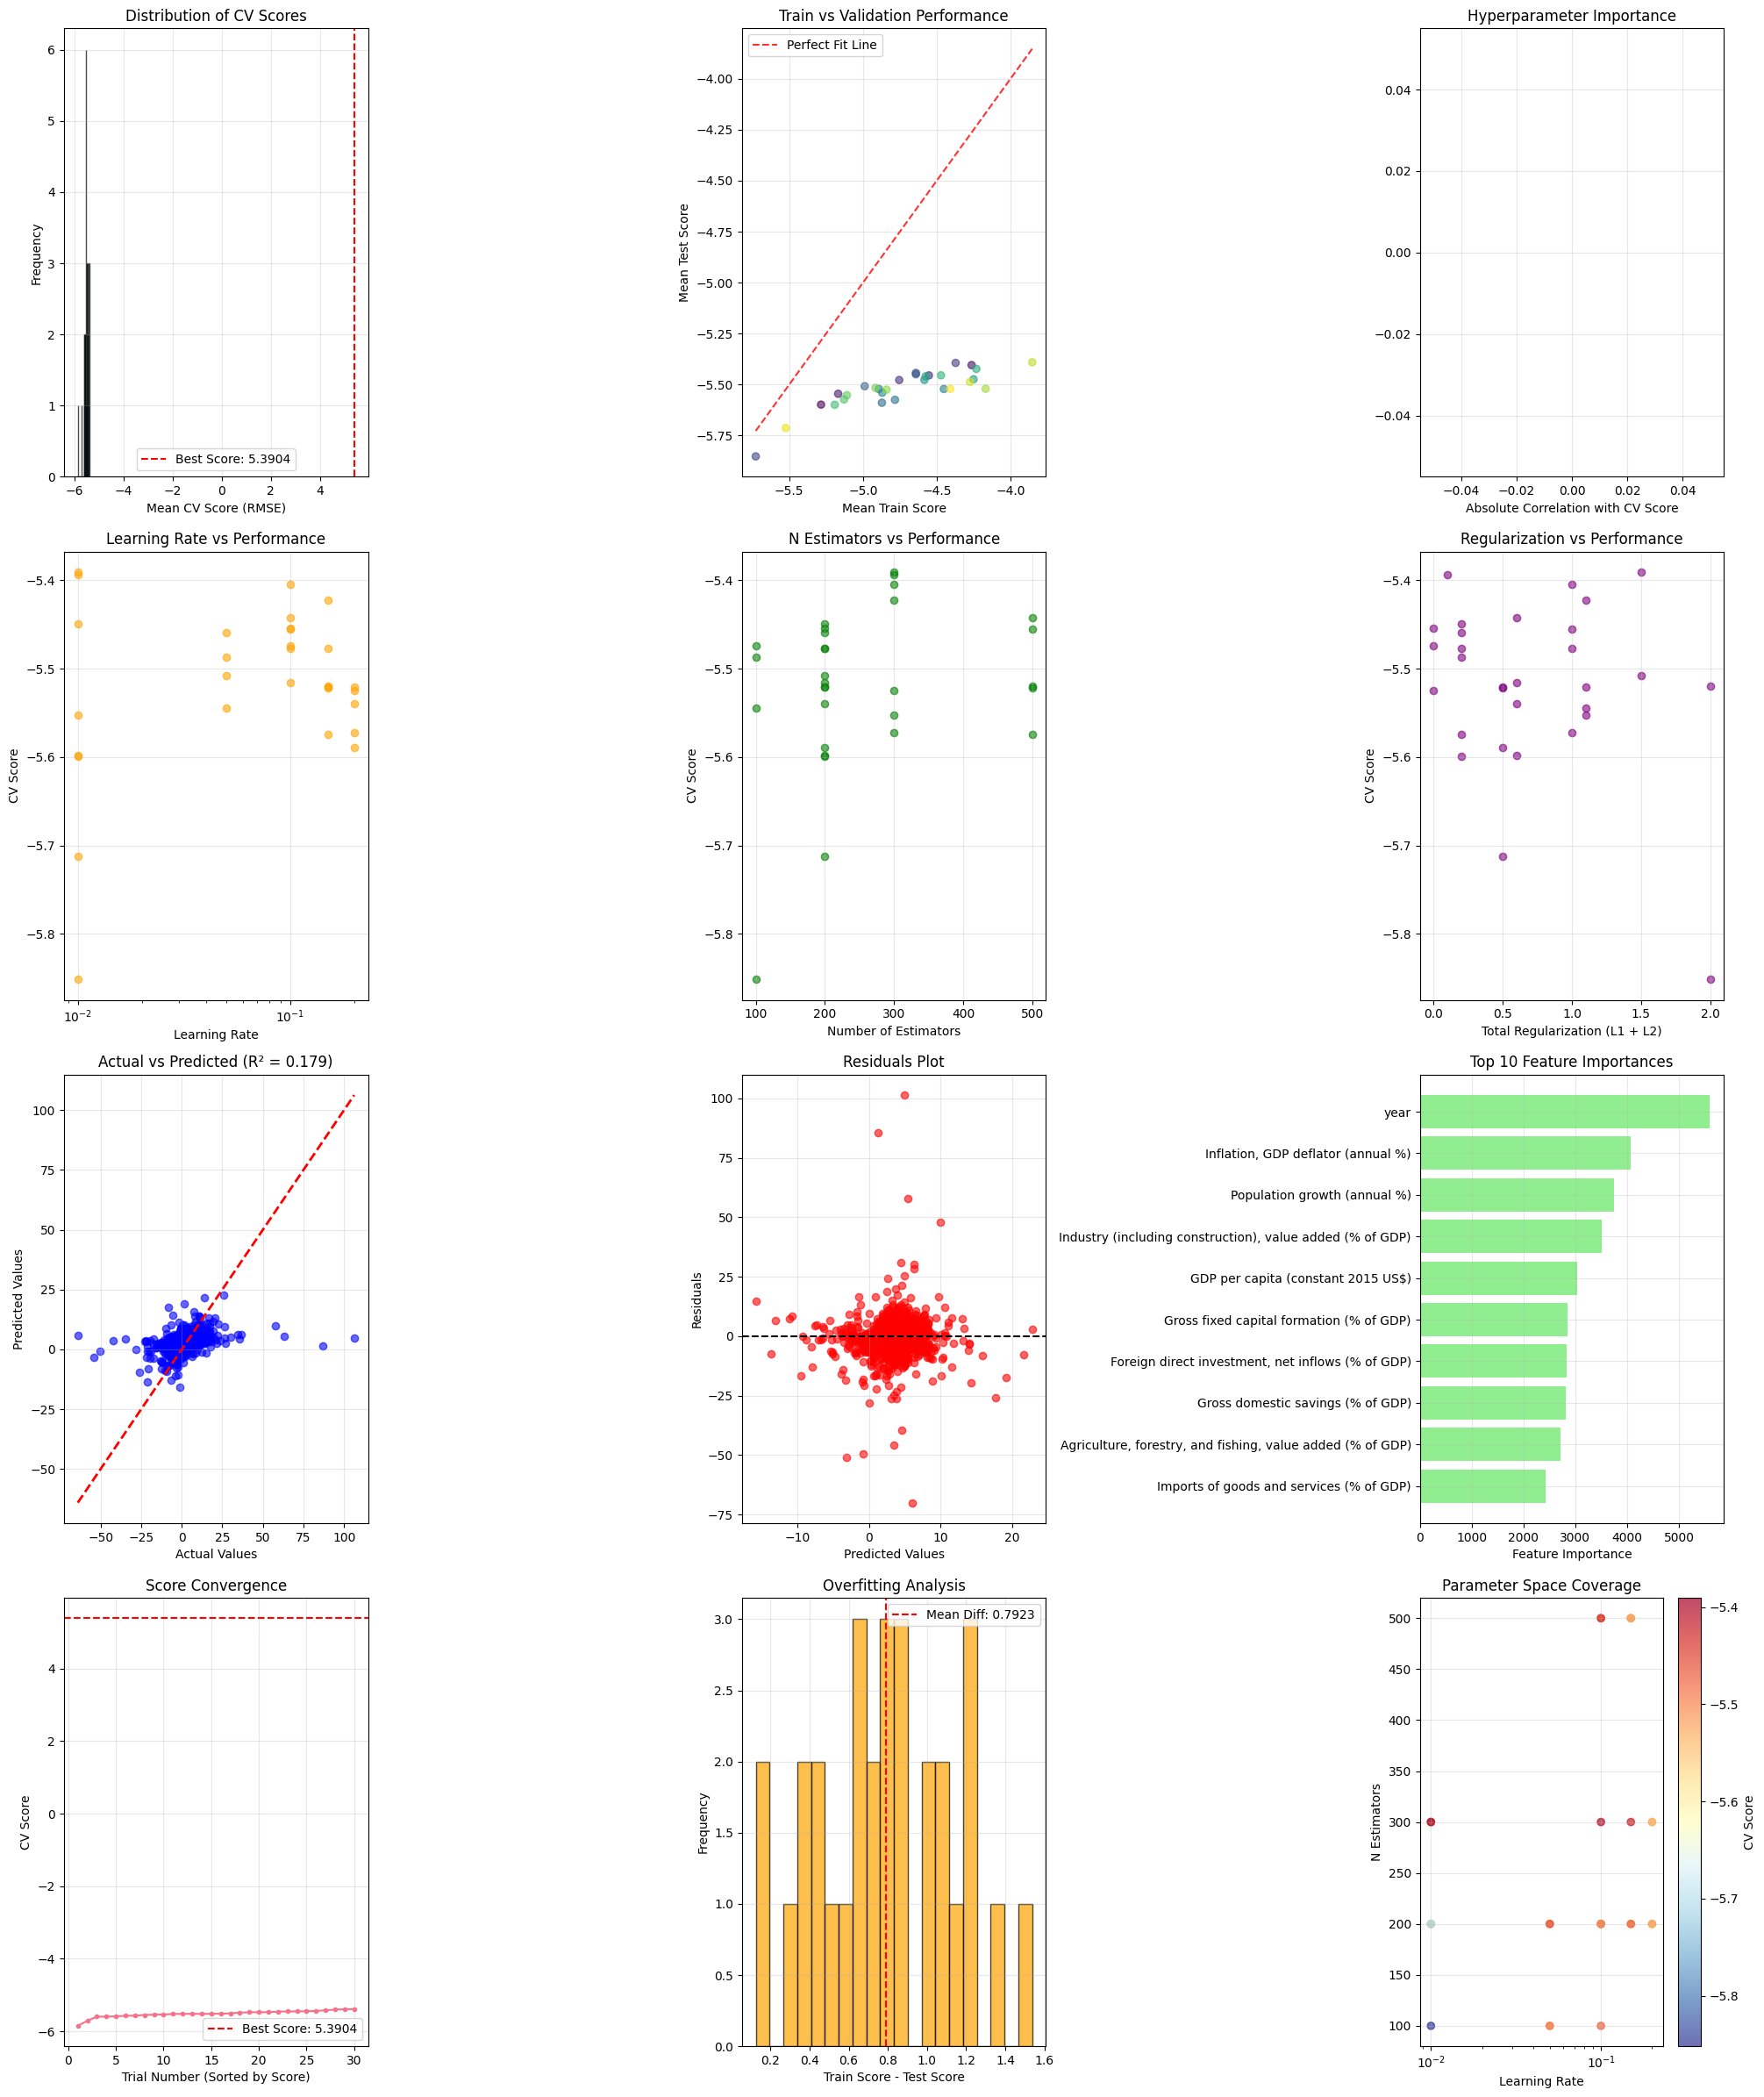

In [57]:

# COMPREHENSIVE VISUALIZATION SECTION
print("\nGenerating comprehensive visualizations...")

# Create results DataFrame for analysis
results_df = pd.DataFrame(random_search.cv_results_)

# Set up the plotting area
fig = plt.figure(figsize=(20, 24))

# 1. CV Score Distribution
ax1 = plt.subplot(4, 3, 1)
plt.hist(results_df['mean_test_score'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(-random_search.best_score_, color='red', linestyle='--', 
           label=f'Best Score: {-random_search.best_score_:.4f}')
plt.xlabel('Mean CV Score (RMSE)')
plt.ylabel('Frequency')
plt.title('Distribution of CV Scores')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Train vs Validation Score
ax2 = plt.subplot(4, 3, 2)
plt.scatter(results_df['mean_train_score'], results_df['mean_test_score'], 
           alpha=0.6, c=range(len(results_df)), cmap='viridis')
plt.plot([results_df['mean_train_score'].min(), results_df['mean_train_score'].max()],
         [results_df['mean_train_score'].min(), results_df['mean_train_score'].max()],
         'r--', alpha=0.8, label='Perfect Fit Line')
plt.xlabel('Mean Train Score')
plt.ylabel('Mean Test Score')
plt.title('Train vs Validation Performance')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Hyperparameter Importance Analysis
ax3 = plt.subplot(4, 3, 3)
# Calculate correlation between hyperparameters and performance
param_importance = {}
for param in param_dist.keys():
    if param in results_df.columns:
        # Handle both numeric and categorical parameters
        param_values = results_df[param]
        if param_values.dtype == 'object':
            # For categorical parameters, use label encoding
            param_values = pd.Categorical(param_values).codes
        correlation = np.corrcoef(param_values, results_df['mean_test_score'])[0, 1]
        param_importance[param.replace('model__', '')] = abs(correlation)

param_importance = dict(sorted(param_importance.items(), key=lambda x: x[1], reverse=True))
params = list(param_importance.keys())[:8]  # Top 8 parameters
importances = [param_importance[p] for p in params]

plt.barh(params, importances, color='lightcoral')
plt.xlabel('Absolute Correlation with CV Score')
plt.title('Hyperparameter Importance')
plt.grid(True, alpha=0.3)

# 4. Learning Rate vs Performance
ax4 = plt.subplot(4, 3, 4)
plt.scatter(results_df['param_model__learning_rate'], results_df['mean_test_score'], 
           alpha=0.6, c='orange')
plt.xlabel('Learning Rate')
plt.ylabel('CV Score')
plt.title('Learning Rate vs Performance')
plt.xscale('log')
plt.grid(True, alpha=0.3)

# 5. Number of Estimators vs Performance
ax5 = plt.subplot(4, 3, 5)
plt.scatter(results_df['param_model__n_estimators'], results_df['mean_test_score'], 
           alpha=0.6, c='green')
plt.xlabel('Number of Estimators')
plt.ylabel('CV Score')
plt.title('N Estimators vs Performance')
plt.grid(True, alpha=0.3)

# 6. Regularization Effect
ax6 = plt.subplot(4, 3, 6)
reg_strength = results_df['param_model__reg_alpha'] + results_df['param_model__reg_lambda']
plt.scatter(reg_strength, results_df['mean_test_score'], alpha=0.6, c='purple')
plt.xlabel('Total Regularization (L1 + L2)')
plt.ylabel('CV Score')
plt.title('Regularization vs Performance')
plt.grid(True, alpha=0.3)

# 7. Actual vs Predicted (Test Set)
ax7 = plt.subplot(4, 3, 7)
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted (R² = {r2:.3f})')
plt.grid(True, alpha=0.3)

# 8. Residuals Plot
ax8 = plt.subplot(4, 3, 8)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.6, color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)

# 9. Feature Importance (if available)
ax9 = plt.subplot(4, 3, 9)
try:
    feature_importance = best_model.named_steps['model'].feature_importances_
    feature_names = (numeric_cols + 
                    [f"country_{cat}" for cat in best_model.named_steps['preprocessor']
                     .named_transformers_['cat'].categories_[0][1:]])  # Skip first due to drop='first'
    
    # Get top 10 features
    importance_df = pd.DataFrame({
        'feature': feature_names[:len(feature_importance)],
        'importance': feature_importance
    }).sort_values('importance', ascending=True).tail(10)
    
    plt.barh(importance_df['feature'], importance_df['importance'], color='lightgreen')
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Feature Importances')
    plt.grid(True, alpha=0.3)
except Exception as e:
    plt.text(0.5, 0.5, f'Feature importance not available:\n{str(e)}', 
            ha='center', va='center', transform=ax9.transAxes)
    plt.title('Feature Importance (Not Available)')

# 10. Cross-Validation Score Convergence
ax10 = plt.subplot(4, 3, 10)
scores_sorted = sorted(results_df['mean_test_score'].values)
plt.plot(range(1, len(scores_sorted) + 1), scores_sorted, marker='o', markersize=3)
plt.axhline(-random_search.best_score_, color='red', linestyle='--', 
           label=f'Best Score: {-random_search.best_score_:.4f}')
plt.xlabel('Trial Number (Sorted by Score)')
plt.ylabel('CV Score')
plt.title('Score Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

# 11. Overfitting Analysis
ax11 = plt.subplot(4, 3, 11)
train_test_diff = results_df['mean_train_score'] - results_df['mean_test_score']
plt.hist(train_test_diff, bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.axvline(train_test_diff.mean(), color='red', linestyle='--', 
           label=f'Mean Diff: {train_test_diff.mean():.4f}')
plt.xlabel('Train Score - Test Score')
plt.ylabel('Frequency')
plt.title('Overfitting Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

# 12. Parameter Space Coverage
ax12 = plt.subplot(4, 3, 12)
# Show coverage of key parameters
lr_values = results_df['param_model__learning_rate']
n_est_values = results_df['param_model__n_estimators']
scatter = plt.scatter(lr_values, n_est_values, 
                     c=results_df['mean_test_score'], 
                     cmap='RdYlBu_r', alpha=0.7)
plt.colorbar(scatter, label='CV Score')
plt.xlabel('Learning Rate')
plt.ylabel('N Estimators')
plt.title('Parameter Space Coverage')
plt.xscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [58]:
# Print summary statistics
print("\n" + "="*60)
print("SEARCH SUMMARY STATISTICS")
print("="*60)
print(f"Total trials completed: {len(results_df)}")
print(f"Best trial index: {random_search.best_index_}")
print(f"Score improvement from worst to best: {results_df['mean_test_score'].max() - results_df['mean_test_score'].min():.4f}")
print(f"Score standard deviation: {results_df['mean_test_score'].std():.4f}")
print(f"Average overfitting (train-test): {train_test_diff.mean():.4f}")

# Save results to CSV for further analysis
results_df.to_csv('lightgbm_hyperparameter_search_results.csv', index=False)
print(f"\nResults saved to 'lightgbm_hyperparameter_search_results.csv'")

print("\nVisualization complete! The plots show:")
print("1. CV score distribution and convergence")
print("2. Train vs validation performance") 
print("3. Hyperparameter importance and effects")
print("4. Model performance analysis")
print("5. Feature importance and parameter space coverage")


SEARCH SUMMARY STATISTICS
Total trials completed: 30
Best trial index: 26
Score improvement from worst to best: 0.4614
Score standard deviation: 0.0943
Average overfitting (train-test): 0.7923

Results saved to 'lightgbm_hyperparameter_search_results.csv'

Visualization complete! The plots show:
1. CV score distribution and convergence
2. Train vs validation performance
3. Hyperparameter importance and effects
4. Model performance analysis
5. Feature importance and parameter space coverage


In [1]:
#Save the model:
import pickle

# Save model
with open('best_lightgbm_pipeline.pkl', 'wb') as f:
    pickle.dump(best_model, f)

NameError: name 'best_model' is not defined

-   My model may look to be overfitting due to economic outliers (like extreme GDP values).

-   My MAPE is 1098884869128848.50%, this suggests some y_test values are near zero, causing division by near-zero when computing. Combined with extreme GDP values, this can make the model look like it's wildly overfitting — when it’s just misfiring on edge cases.

-   On the other hand, this model generalizes much worse on the test set, which often means it's being thrown off by unseen or rare economic patterns

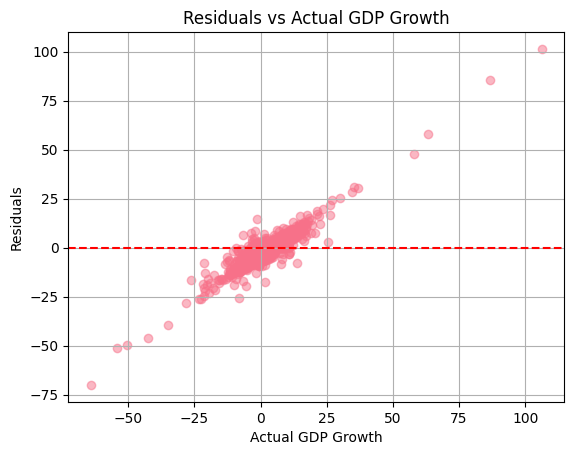

In [59]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual GDP Growth")
plt.ylabel("Residuals")
plt.title("Residuals vs Actual GDP Growth")
plt.grid(True)
plt.show()

### I can see from this:

That my model works reasonably well for the central GDP values (say, -10% to +20%), but fails to generalize to extreme economic scenarios, likely because:
- These are rare in your training data
- The model is regularized and can’t fit these extremes
- Outliers dominate RMSE and especially MAPE

### Things I could do to fix this:

-   1. Clipping or Winsorizing Target Values: Limit extreme GDP growth values (e.g., clipping to [-25%, +25%])

        + Simple and fast to implement.
        + Reduces the impact of extreme outliers on RMSE and overfitting.
        + Preserves the interpretability of the target.

        - You lose information about real (but rare) economic scenarios.
        - Can bias the model if those clipped values are frequent in certain countries or years.
        - Makes it impossible to predict values beyond the chosen range.

    Warnings:  This is best when outliers are rare and not critical to your use case.


-   2.  Log-Transforming (or Box-Cox) the Target: Apply np.log1p() to reduce skew in GDP growth.

        + Helps normalize skewed distribution.
        + Compresses large values and reduces the dominance of outliers.

        - GDP growth can be negative, and log1p() is undefined for values < -1
        - Predictions must be transformed back, which introduces distortion or error when reversing.
        - Makes it impossible to predict values beyond the chosen range.

    Warnings:  This would be best if we´d want smooth behavior and have mostly positive or shifted GDP values.


-   3. Remove or Segment Outliers:Detect and remove extreme GDP entries or treat them as a separate model task

        + Clean training data leads to better average-case performance.
        + Allows for a specialized model on extreme cases if needed.

        - Requires manual analysis or rules to define what’s “extreme.”
        - May exclude real-world, high-impact cases from your model.
        - Breaks the “global” nature of GDP forecasting across countries.

    Warnings:  This would be best if our outliers were rare and clearly different from your core dataset (e.g., conflict states, pandemics).

-   4. Robust Loss Functions (huber, quantile, fair): Change the LightGBM loss function to reduce sensitivity to outliers.

        + No need to modify the target or features..
        + Directly reduces the influence of extreme residuals.
        + Keeps model predictions realistic and better generalizing.

        - Slightly slower training.
        - Some loss functions (e.g., quantile) require parameter tuning (alpha).
        - May smooth too much and underfit high-variance targets.

    Warnings:  This would be best if we´d want to keep the full data but reduce outlier sensitivity smartly.
